In [1]:
%matplotlib inline


from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *
import time
import random
from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE, SimpleFunctionPE
from clipc_combine_process import clipc_combine_process_d4p
from clipc_combine_process import serve_netcdf_d4p

import matplotlib.pyplot as plt
import traceback

# project: CLIP_C
# authors: Alessandro and Andrej
# CLIPC combine function using dispel4py and running over jupyter
# [mihajlov@pc150396 ~]$ .local/bin/jupyter-notebook 

#print __dir__

print "/usr/people/mihajlov/python/clipc/clipccombine"
print "CLIPC dispel4py running"

class Collector(GenericPE):
        
    def __init__(self):
        #IterativePE.__init__(self)
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output_R')
        #self._add_output('output_W')
        self.counter = 0;
        
    def _process(self,inputs):
        print inputs
        
        url1 = inputs['input'][0]
        url2 = inputs['input'][1]
     
        index = str(self.counter)
    
        # first  url collected
        nc1 = clipc_combine_process_d4p.collect(url1)
        self.write('output_R',(  index , 0 , nc1 ))
   
        #second url collected
        #counter = counter + 1
        nc2 = clipc_combine_process_d4p.collect(url2)
        self.write('output_R',( index , 1 , nc2 ))
      
        # output written...
        nc_out = clipc_combine_process_d4p.write(nc1 , "d4pout/output"+index+".nc" , "dr drej n spinuso rock the data flow.")
        
        #
        self.log(type(nc_out))  
        
        #
        self.write('output_W',( index , nc_out))
        
        self.counter += 1
              
    
# def readn(data):
#     prov={'format':'Random float', 'metadata':{'value':str(data)}}
#     return {'_d4p_prov':prov,'_d4p_data':data}
        
        
# def multn(data): 
#     prov={'format':'Random float', 'metadata':{'value':data*data}}
#     print data
#     return {'_d4p_prov':prov,'_d4p_data':data*data}

    
def reader(data):
    #nc = clipc_combine_process_d4p.collect(url)
    #print "reader with data:" , str(data)
    
    var , norm = clipc_combine_process_d4p.read(data[2])

    return ( data[0] , data[1] , var , norm)


##################################

class Match(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input', grouping=('prov',[0]))
        #self._add_input('input2')
        self._accumulator = {}
        self._add_output('output_X')
        
    
    def _process(self,inputs):
        #self.log(  inputs )
        
        #url1,url2 = inputs['input'][0]
        #self._accumulator.append(inputs['input'])
        #self._accumulator.append(inputs['input2'])
        
        inp = inputs['input']
        
        #print inp[0]
        #print inp[1]
        #print len(inp[2])                
        #print inp[3]
        
        #inputs(str(0),element,var,norm)
        self.log( "received counter "+inp[0])
        
        k = str(inp[0])
        if k not in self._accumulator.keys():
            self._accumulator[k] = {} 
        
        self._accumulator[k][inp[1]] = ( inp[2] , inp[3] ) 
        
        # if( len(self._accumulator ) == 2 ):
        if( len(self._accumulator[str(inp[0])].keys() ) == 2 ):
            #combine(self._accumulator)
            
            output = self._accumulator.pop(k)
            
            self.write('output_X', (k , output[0] , output[1]) )

            #print self._accumulator[k].keys()
            
        #nc1 = clipc_combine_process_d4p.collect(url1)
        #self.write('output_R',nc1)
   
        #nc_out = clipc_combine_process_d4p.write(nc1 , "output.nc" , "dr drej n spinuso rock the data flow.")
        #self.write('output_W',nc_out)
        
        #nc2 = clipc_combine_process_d4p.collect(url2)
        #self.write('output_R',nc2)
        
def combine(data,operator):
    comb_var = clipc_combine_process_d4p.combine( data[1][0] , data[1][1] , data[2][0] , data[2][1] , operator)
    
    return ( data[0] , comb_var)


    
class Writer(GenericPE):

    def __init__(self,op):
        GenericPE.__init__(self)
        self._add_input('file' , grouping=('prov',[0]))
        self._add_input('var'  , grouping=('prov',[0]))
        self._opp = op
        self._accumulator = []
        self._add_output('final')
        
        # index hash
        self.file = {}
        self.var  = {}
        
    def _process(self,inputs):
        self.log(str(inputs))
      
        index = None
        
        try:
            if 'file' in inputs:
                f = inputs['file']
                index = f[0]
                self.file[index]=f[1]
            elif 'var' in inputs:
                v = inputs['var']   
                index = v[0]
                self.var[index]=v[1]

            self.log("index writen:"+index)      
        except:
            print "exception for writer input: " , index 
            traceback.print_exc(file=sys.stdout)
            return
        
        try:
            if (self.var[index] != None and self.file[index] != None):
                x=clipc_combine_process_d4p.postprocess(self.var.pop(index),self.file.pop(index))
                self.write('final',x[0])
        except:
            print "andrej exception send " , index , " in " , self.file.keys() , self.var.keys()
            #traceback.print_stack()
            traceback.print_exc(file=sys.stdout)
            
class Visualiser(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_input('res')
        #self._accumulator = []
        #self.plot
    
    def _process(self,inputs):
        #print inputs
        
        #self._accumulator.append(inputs['input'])
        fig = plt.figure(1)
        
        serve_netcdf_d4p.visualise1(fig, inputs['input']  )
        
        self.write('res',{})
    
###################################




sc1 = Collector()
sc1.name = 'collector'

sc2 = Match()
sc2.name = 'match'

sc3 = Writer("+")
sc3.name = 'writer'

sc4 = Visualiser()
sc4.name = 'vizu'

read=SimpleFunctionPE(reader)
comb=SimpleFunctionPE(combine,{"operator":"+"})
 

#processes=[readn,multn]
#chain = create_iterative_chain(processes, FunctionPE_class=SimpleFunctionPE)

#Initialise the graph
graph = WorkflowGraph()

#Common way of composing the graph
graph.connect(sc1,'output_R',read,'input')
graph.connect(read,'output', sc2,'input')
graph.connect(sc2,'output_X',comb,'input')
graph.connect(comb,'output',sc3,'var')
graph.connect(sc1,'output_W',sc3,'file')
graph.connect(sc3,'final',sc4,'input')

# Alternatively with pipeline array
#Create pipelines from functions

#graph.connect(sc,'output',chain,'input')



graph.flatten()


# /usr/people/mihajlov/python/clipc/clipccombine/clipc_combine_process
# file running: combine_netcdf.py
# def combine_two_indecies(url1,url2,operation,output,...):


#Prepare Input
url1 = 'example/vDTR_JUN_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc'
url2 = 'example/vDTR_OCT_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc'

input_data = {"collector": [{"input": [url1,url2]},{"input": [url1,url2]},{"input": [url1,url2] }]}

print 'inputs.clipc'                                                     
print input_data                   
                                                     
#Launch in simple process
simple_process.process_and_return(graph, input_data)


#plt.show()



/usr/people/mihajlov/python/clipc/clipccombine
CLIPC dispel4py running
SETTING NAME: Collector
SETTING NAME: Match
SETTING NAME: Writer
SETTING NAME: Visualiser
SETTING NAME: SimpleFunctionPE
SETTING NAME: SimpleFunctionPE
inputs.clipc
{'collector': [{'input': ['example/vDTR_JUN_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc', 'example/vDTR_OCT_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc']}, {'input': ['example/vDTR_JUN_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc', 'example/vDTR_OCT_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc']}, {'input': ['example/vDTR_JUN_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc', 'example/vDTR_OCT_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc']}]}
SETTING NAME: SimpleProcessingPE
{'input': ['example/vDTR_JUN_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc', 'example/vDTR_OCT_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc']}


TypeError: coercing to Unicode: need string or buffer, Dataset found

In [ ]:
%matplotlib inline


ProvenanceRecorderToServiceBulk.REPOS_URL='http://verce-portal-dev.scai.fraunhofer.de/j2ep-1.0/prov/workflow/insert'
rid='RDWD_'+getUniqueId()
InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='aspinuso',runId=rid,w3c_prov=False,workflowName="test_rdwd",workflowId="xx")

simple_process.process_and_return(graph, input_data)

#plt.show()
#from IPython.display import HTML
#HTML("<iframe src='http://127.0.01:8080/provenance-explorer/html/d3js.jsp?level=PE&runId="+rid+"' width=800 height=800></iframe>")

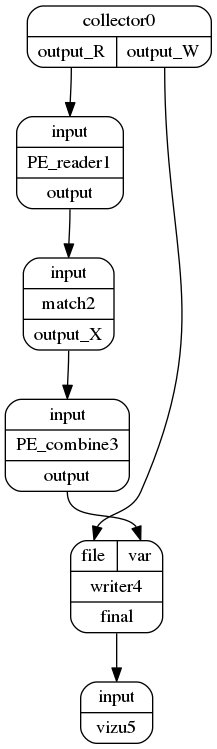

In [2]:
from dispel4py.visualisation import display

display(graph)

In [3]:

ProvenanceRecorderToServiceBulk.REPOS_URL='http://verce-portal-dev.scai.fraunhofer.de/j2ep-1.0/prov/workflow/insert'
rid='RDWD_'+getUniqueId()
#InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='aspinuso',runId=rid,w3c_prov=False,workflowName="test_rdwd",workflowId="xx")

extra_args=['-n', '3']
dispel4py.new.processor.process_and_return(graph, input_data, 'multi',extra_args)



#from IPython.display import HTML
#HTML("<iframe src='http://127.0.01:8080/provenance-explorer/html/d3js.jsp?level=instances&runId="+rid+"' width=800 height=800></iframe>")

Exception AttributeError: "'netcdf_file' object has no attribute 'fp'" in <bound method netcdf_file.close of <scipy.io.netcdf.netcdf_file object at 0x7f22e9840810>> ignored


AttributeError: 'module' object has no attribute 'process_and_return'

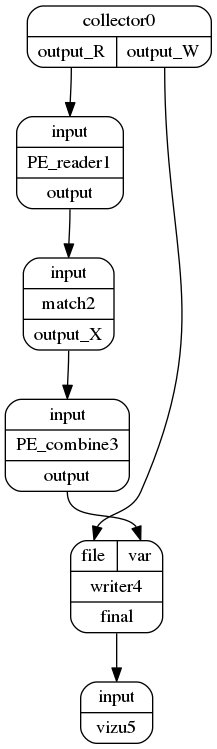

In [4]:
from dispel4py.visualisation import display

display(graph)